In [1]:
#importing libraries
import pandas as pd
import numpy as np

from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

import scipy.stats
import matplotlib.pyplot as plt


In [2]:
# define file path
file_path = '860_Assignment1_Data_vf.xlsx'

### Question 1

In [6]:
# load data from excel file
df_locations = pd.read_excel(file_path, sheet_name='Windfarm Turbine Locations')
df_turbine = pd.read_excel(file_path, sheet_name='Turbine Specifications')
df_weather = pd.read_excel(file_path, sheet_name='Island Airport Weather',skiprows=16)


#### UDF

In [9]:
#Extract turbine specifications
def turbine_specs(df, field):
    value = df.loc[df['Field'] == field, 'Values'].iloc[0]
    return value

#### Question 1.a

In [12]:
df_weather['Air Density (kg/m3)'] = (df_weather['Stn Press (kPa)'] * 1000) / (287.05 * (df_weather['Temp (°C)'] + 273.15))
df_weather[['Air Density (kg/m3)']].head()

,Air Density (kg/m3)
0,1.236659
1,1.232853
2,1.230567
3,1.247307
4,1.253480


#### Question 1.b

In [15]:
df_weather["Wind Spd (m/s)"]=df_weather["Wind Spd (km/h)"]*0.277778
df_weather[["Wind Spd (m/s)"]].head()

,Wind Spd (m/s)
0,3.055558
1,1.111112
2,7.777784
3,9.444452
4,7.777784


#### Question 1.c

In [18]:
#extract specifications data from specifications sheet
swept_area                  = turbine_specs(df_turbine, 'Turbine swept area')
min_speed                   = turbine_specs(df_turbine, 'Cut-in windspeed (m/s)')
max_speed                   = turbine_specs(df_turbine, 'Cut-out windspeed (m/s)')
nominal_power               = turbine_specs(df_turbine, 'Turbine nominal power')
max_power_coeff             = turbine_specs(df_turbine, 'Maximum power coefficient')


In [20]:
df_weather['Power (watts)']  = df_weather['Air Density (kg/m3)'] * swept_area * 0.5 * max_power_coeff * (df_weather["Wind Spd (m/s)"] ** 3)

#No power generated when Wind speed outside cutoff speeds
df_weather.loc[
    (df_weather["Wind Spd (m/s)"] > max_speed) | (df_weather["Wind Spd (m/s)"] < min_speed),
    "Power (watts)"
] = 0

#Max poewr cut-off
df_weather["Power (watts)"] = df_weather["Power (watts)"].apply(
    lambda x: min(x, nominal_power * 1_000_000)
)

df_weather.head()

,Month,Day,Time,Temp (°C),Temp Flag,Dew Point Temp (°C),Dew Point Temp Flag,Rel Hum (%),Rel Hum Flag,Wind Dir (10s deg),...,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather,Air Density (kg/m3),Wind Spd (m/s),Power (watts)
0,1,1,00:00:00,4.3,NaN,4.0,NaN,98,NaN,8.0,...,98.49,NaN,NaN,NaN,NaN,NaN,"Rain,Fog",1.236659,3.055558,0.000000e+00
1,1,1,01:00:00,5.1,NaN,5.0,NaN,99,NaN,NaN,...,98.47,NaN,NaN,NaN,NaN,NaN,NaN,1.232853,1.111112,0.000000e+00
2,1,1,02:00:00,5.9,NaN,5.6,NaN,98,NaN,31.0,...,98.57,NaN,NaN,NaN,NaN,NaN,"Rain,Fog",1.230567,7.777784,1.344892e+06
3,1,1,03:00:00,3.3,NaN,2.6,NaN,95,NaN,30.0,...,98.98,NaN,NaN,NaN,NaN,NaN,NaN,1.247307,9.444452,2.440722e+06
4,1,1,04:00:00,2.8,NaN,1.2,NaN,89,NaN,30.0,...,99.29,NaN,NaN,NaN,NaN,NaN,NaN,1.253480,7.777784,1.369935e+06


#### Question 1.d

In [23]:
# Total power generated in january in MegaWatts
total_power = df_weather['Power (watts)'].sum()/1000000
print(f"Total power generated in January is {total_power:.2f} MW")

Total power generated in January is 879.14 MW


#### Question 1.e

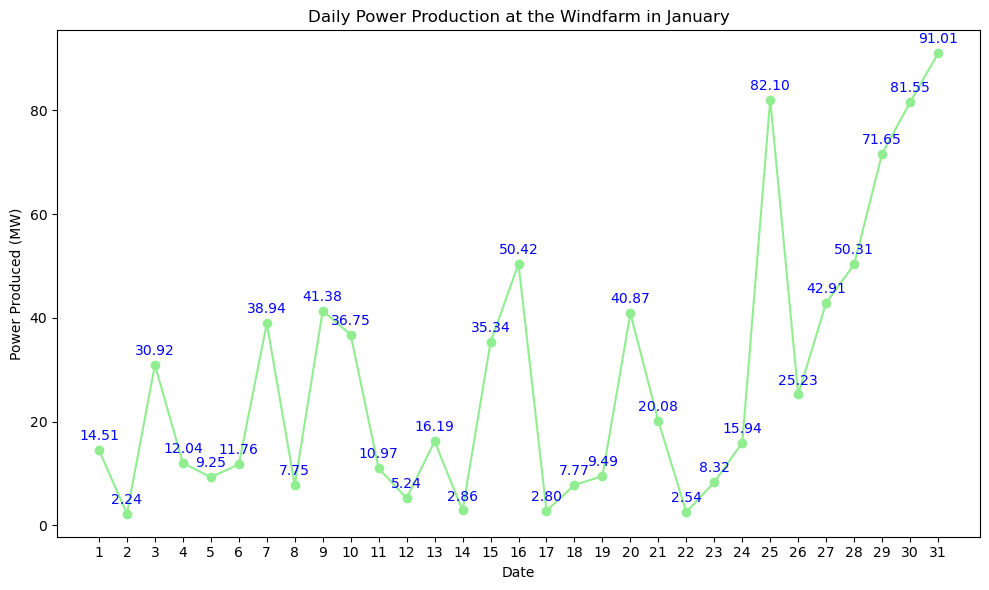

In [26]:


# Group by date and sum the power produced in megawatts
daily_power = df_weather.groupby(df_weather['Day'])['Power (watts)'].sum() / 1_000_000

# Plot the daily power production
plt.figure(figsize=(10,6))

# bars = daily_power.plot(kind= 'bar', color='skyblue', edgecolor='red',)
# # Annotate the bars with the power produced
# for bar in bars.patches:
#     bars.annotate(format(bar.get_height(), '.2f'),
#                   xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
#                   xytext=(0, 3),  # 3 points vertical offset
#                   textcoords="offset points",
#                   ha='center', va='bottom')

# line plot of the daily power production
ax1 = daily_power.plot(kind='line', color='lightgreen', marker='o')
for x, y in zip(daily_power.index, daily_power.values):
    ax1.annotate(f'{y:.2f}', 
                 xy=(x, y), 
                 xytext=(0, 5), 
                 textcoords='offset points', 
                 ha='center', 
                 va='bottom', 
                 color='blue')
    
ax1.set_xticks(daily_power.index)

plt.title('Daily Power Production at the Windfarm in January')
plt.xlabel('Date')
plt.ylabel('Power Produced (MW)')
plt.tight_layout()
plt.show()

### Question 3

In [29]:
# import data from excel file
df_sales = pd.read_excel("860_Assignment1_Data_vf.xlsx", sheet_name="Product_Sales")

#### Question 3.a

In [32]:
# check data type for each column 
df_sales.dtypes

Obs                int64
Product_ID         int64
Sales_2016       float64
Sales_2017       float64
Import             int64
Num_Retailers      int64
Price             object
dtype: object

In [34]:
# Formatting variables
# change Product_ID to string
df_sales ['Product_ID'] = df_sales ['Product_ID'].astype(str)

# ensure Product_ID are same length 
max_padding = df_sales['Product_ID'].str.len().max()
df_sales ['Product_ID'] = df_sales ['Product_ID'].str.zfill(max_padding)
# change price to float
# UDF to remove dollar sign for price:

def Remove_Dollar_Sign(s):
    return s.replace("$","")

df_sales["Price"]=df_sales["Price"].map(Remove_Dollar_Sign).astype('float64')
# print first five rows check changes
df_sales.head()

,Obs,Product_ID,Sales_2016,Sales_2017,Import,Num_Retailers,Price
0,1,001,1162.91,235.19,1,5,67.18
1,2,002,1191.11,944.87,1,3,54.56
2,3,003,1214.96,737.06,0,5,58.85
3,4,004,1336.07,986.15,0,7,56.48
4,5,005,1343.29,871.33,1,7,58.74


#### Question 3.b

In [37]:
#removing duplicates
df_sales    = df_sales.drop_duplicates()
df_sales    = df_sales.dropna()

#removing leading/trailing spaces
df_sales.columns    = df_sales.columns.str.strip()

#Check for nulls
null_counts = df_sales.isnull().sum()
null_counts


Obs              0
Product_ID       0
Sales_2016       0
Sales_2017       0
Import           0
Num_Retailers    0
Price            0
dtype: int64

In [39]:
# Find comma-separated values
print(df_sales.map(lambda x: "," in str(x)).sum()) 

Obs              0
Product_ID       0
Sales_2016       0
Sales_2017       0
Import           0
Num_Retailers    0
Price            0
dtype: int64


#### Question 3.c

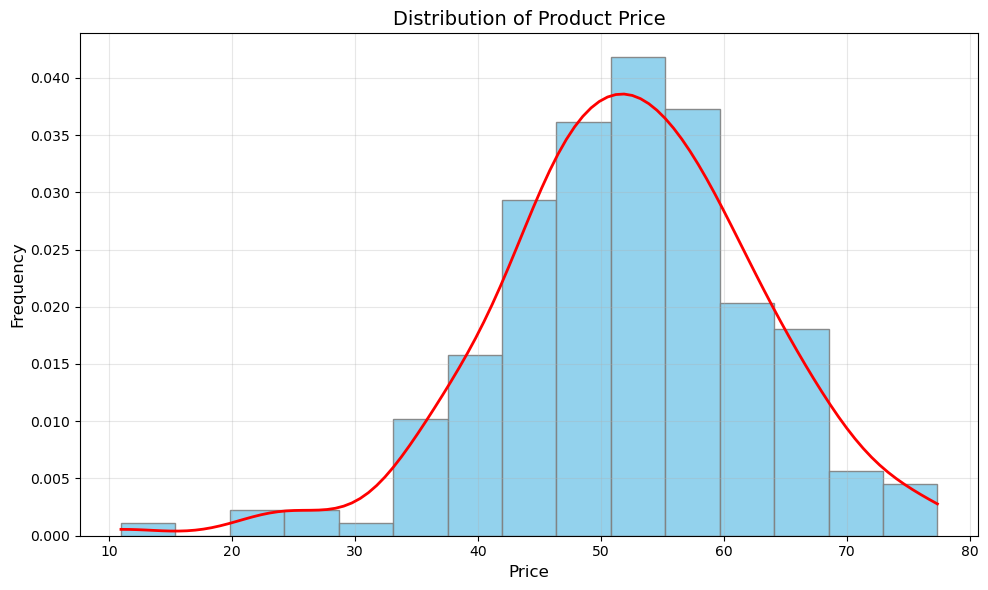

In [42]:
# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_sales['Price'], bins=15, density=True, alpha=0.9, color='skyblue', edgecolor='grey')

# Add KDE curve - pretty smooth the curve 
density = stats.gaussian_kde(df_sales['Price'])
x_vals = np.linspace(df_sales['Price'].min(), df_sales['Price'].max(), 100)
plt.plot(x_vals, density(x_vals), 'r-', linewidth=2)

# Add labels and title
plt.title('Distribution of Product Price', fontsize=14)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Show the plot
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### Question 3.d

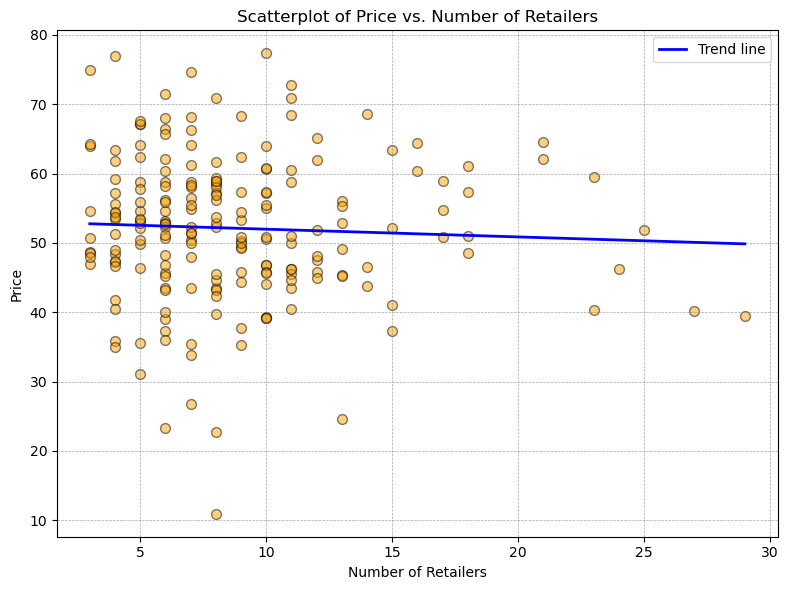

In [45]:
plt.figure(figsize=(8,6))  
   
 # Scatter plot 
plt.scatter(df_sales['Num_Retailers'], df_sales['Price'],   
             color='orange', alpha=0.5, edgecolor='k', s=50)  
   
 # add trend line  
slope, intercept, r_value, p_value, std_err = stats.linregress(df_sales['Num_Retailers'], df_sales['Price'])  
x_vals = np.array([df_sales['Num_Retailers'].min(), df_sales['Num_Retailers'].max()])  
plt.plot(x_vals, intercept + slope * x_vals, color='blue', lw=2, label='Trend line')  
   
plt.title('Scatterplot of Price vs. Number of Retailers')  
plt.xlabel('Number of Retailers')  
plt.ylabel('Price')  
plt.legend()  
plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.7)  
plt.tight_layout()  
plt.show()  

#### Question 3.e

Import   Domestic   Imported
2016    198006.13  101063.35
2017    193086.52   84172.96


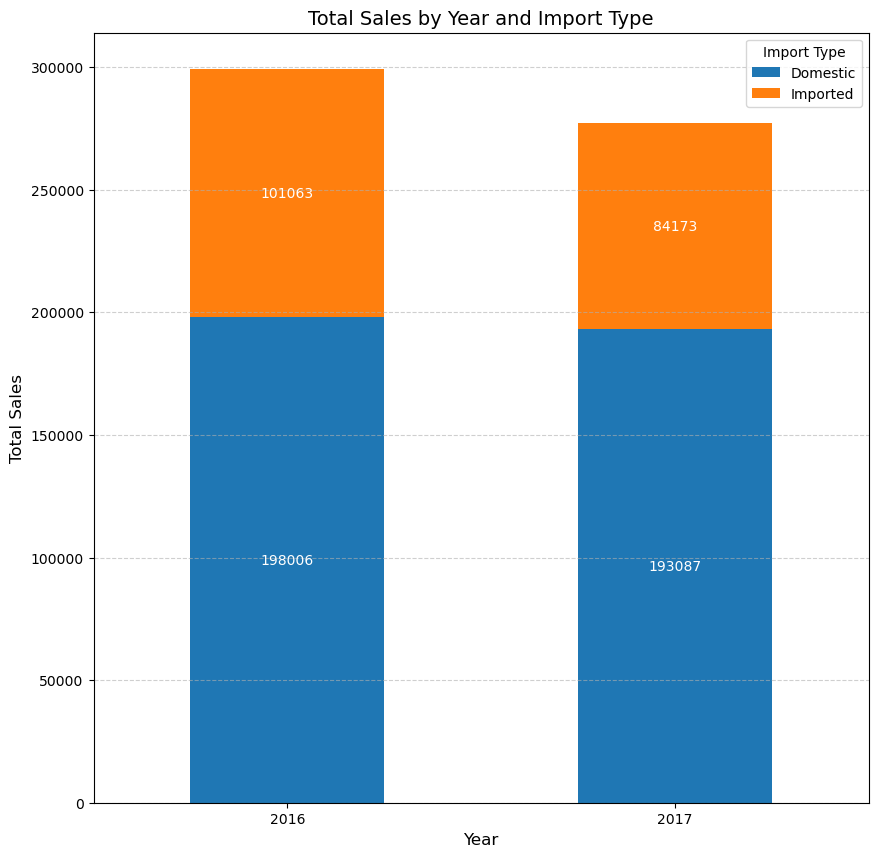

In [48]:
# calculate the total sales for 2016 and 2017

sales_summary   = df_sales.groupby("Import")[["Sales_2016", "Sales_2017"]].sum().T

sales_summary.index=["2016", "2017"]
sales_summary.columns = sales_summary.columns.map({0: "Domestic", 1: "Imported"})

print (sales_summary)
# create a stacked bar chart
fig, ax = plt.subplots(figsize=(10, 10))
sales_summary.plot(kind="bar", stacked=True,  ax=ax)
sales_summary = sales_summary.columns.map({0:"Domestic", 1:"Imported"})
# labels and title
plt.title("Total Sales by Year and Import Type", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)
plt.legend(title="Import Type", loc="upper right")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", label_type="center", fontsize=10, color="white")
    
plt.show()

### Question 4

#### UDF

In [52]:
#Perform Linear Regression
def lin_reg(df, features):
    variables   = df[features]
    y_value     = df["Y"]

    #run linear regression fitting
    reg = linear_model.LinearRegression()
    reg.fit(variables, y_value)

    #Calcute R-square value
    r2 = reg.score(variables, y_value)

    #Feature comparison
    width = 140 
    print("\n" + "*" * width)
    print(f"\033[1mY vs {', '.join(features)}\033[0m".center(width))
    print("*" * width + "\n")

    #Linear regression equation
    equation = ""
    for coef, feat in zip(reg.coef_, features):
        equation += f"({coef:.2f} x {feat}) + "

    print(f"The linear regression model for {len(df)} observations is: Y = {equation}({reg.intercept_:2f})")
    print(f"R-squared value: {r2:.5f}")

    #Update dataframe with linear regression values
    df['Y_calc'] = reg.predict(variables)

    return df

In [54]:
#Plot linear regression data
def plot_lin_reg(df, features):
    df = lin_reg(df, features)

    x_axis      = df["Y_calc"]
    y_axis      = df["Y"] - df["Y_calc"]

    plt.figure(figsize=(15,5))
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.scatter(x_axis, y_axis, s=35, c='black')

    plt.hlines(0,min(x_axis),max(x_axis),color='red',linestyles='dashed')
            
    plt.xlabel("Model Prediction")
    plt.ylabel("Residual")

    plt.title(f"{len(df)} Observations - Comparison of Residuals and Fitted Values")

    plt.show()

In [56]:
#Statistical Linear regression
def stat_lin_reg(df, features):
    model   = ols(f"Y ~ {' + '.join(features)}", data=df)
    model   = model.fit()

    #Feature comparison
    width = 140
    print("\n" + "=" * width)
    print(f"Y vs {', '.join(features)}".center(width))
    print("=" * width + "\n")

    print(model.summary())

In [58]:
#Histogram for linear regression
def plot_histogram(df, features):
    df = lin_reg(df, features)

    y_axis      = df["Y"] - df["Y_calc"]

    mean, std   = scipy.stats.norm.fit(y_axis)
    x           = np.linspace(min(y_axis), max(y_axis), 100)
    p           = scipy.stats.norm.pdf(x, mean, std)

    plt.hist(y_axis, bins=13, density=True, alpha=0.7, edgecolor ='black')
    plt.plot(x, p, linestyle='solid', linewidth=2, color='black')

    plt.title(f"{len(df)} Obersations - Fit Results: mu = {mean:.2f},  std = {std:.2f}")

    plt.show()

#### Question 4a: Collinearity Analysis

In [61]:
df_coll    = pd.read_excel(file_path, sheet_name="Collinearity")

In [63]:
features_set1   = ['Experience', 'Height']
features_set2   = ['Experience', 'Weight']
features_set3   = ['Experience', 'Height', 'Weight']

features        = [features_set1, features_set2, features_set3]

##### Linear Regression & Statistical Analysis

##### 25 Observations


********************************************************************************************************************************************
                                                      Y vs Experience, Height                                                       
********************************************************************************************************************************************

The linear regression model for 25 observations is: Y = (101.77 x Experience) + (1.67 x Height) + (-39.538853)
R-squared value: 0.87844


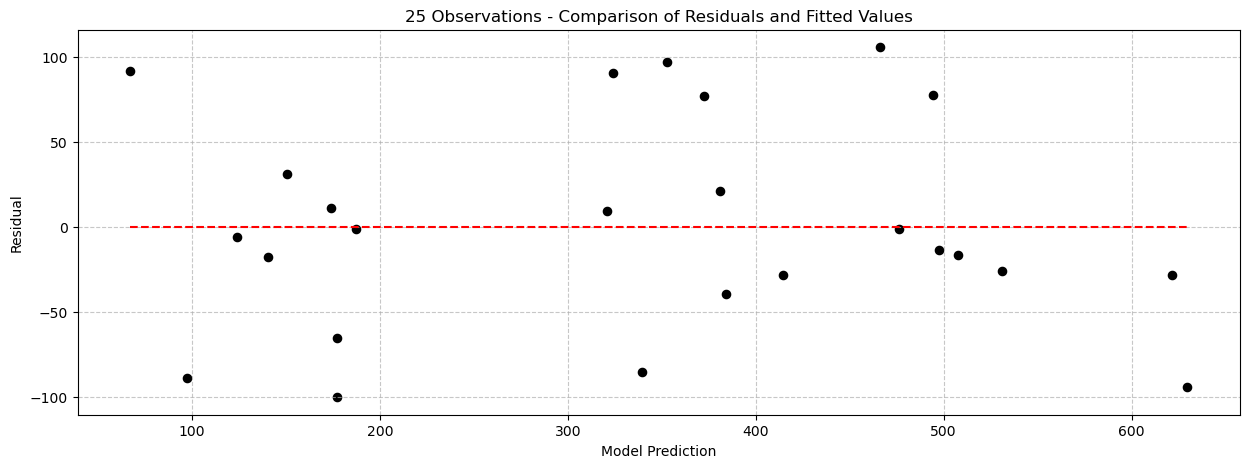


                                                          Y vs Experience, Height                                                           

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     79.49
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           8.56e-11
Time:                        19:35:00   Log-Likelihood:                -138.40
No. Observations:                  25   AIC:                             282.8
Df Residuals:                      22   BIC:                             286.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025 

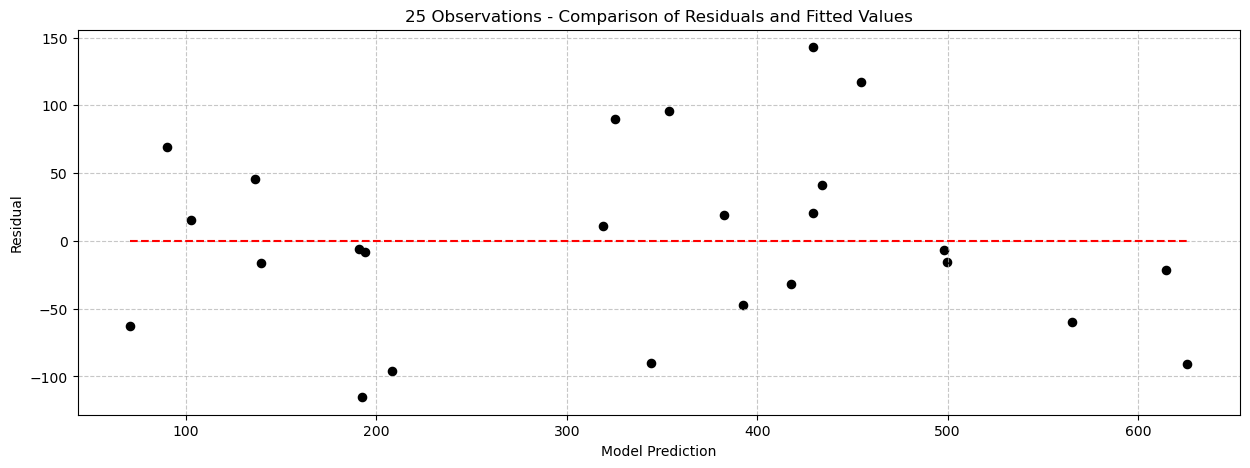


                                                          Y vs Experience, Weight                                                           

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     65.01
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           5.83e-10
Time:                        19:35:01   Log-Likelihood:                -140.58
No. Observations:                  25   AIC:                             287.2
Df Residuals:                      22   BIC:                             290.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025 

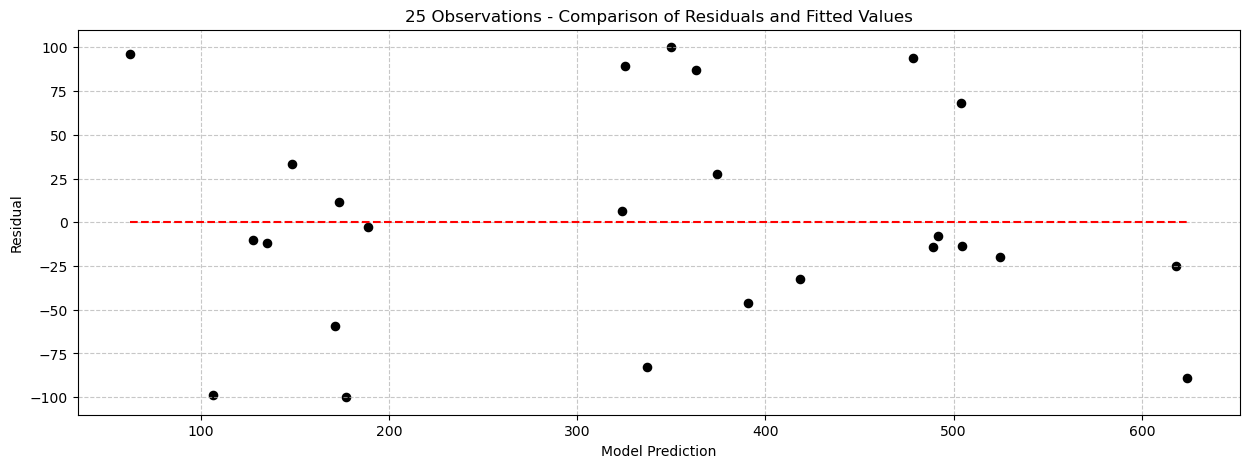


                                                      Y vs Experience, Height, Weight                                                       

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     51.17
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           7.89e-10
Time:                        19:35:01   Log-Likelihood:                -138.27
No. Observations:                  25   AIC:                             284.5
Df Residuals:                      21   BIC:                             289.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025 

In [67]:
#Part i, ii, iii - Running Linear regression for 25 observations

df_coll_25  = df_coll.iloc[:25]
df_coll_25  = df_coll_25.copy()

for feat in features:
    plot_lin_reg(df_coll_25, feat)
    stat_lin_reg(df_coll_25, feat)

##### 100 Observations


********************************************************************************************************************************************
                                                      Y vs Experience, Height                                                       
********************************************************************************************************************************************

The linear regression model for 100 observations is: Y = (96.25 x Experience) + (1.28 x Height) + (0.924141)
R-squared value: 0.84020


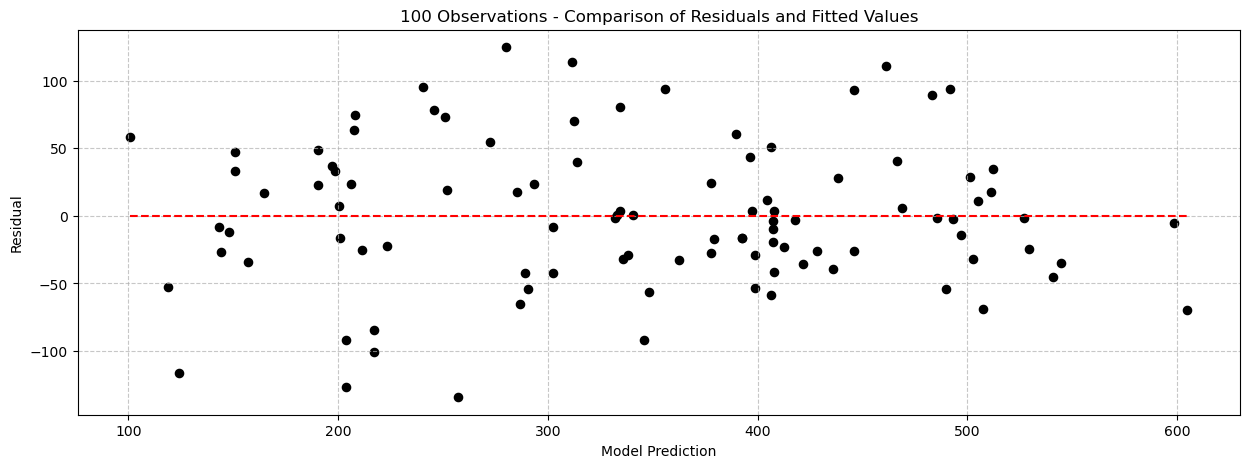


                                                          Y vs Experience, Height                                                           

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     255.0
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           2.36e-39
Time:                        19:35:04   Log-Likelihood:                -540.07
No. Observations:                 100   AIC:                             1086.
Df Residuals:                      97   BIC:                             1094.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025 

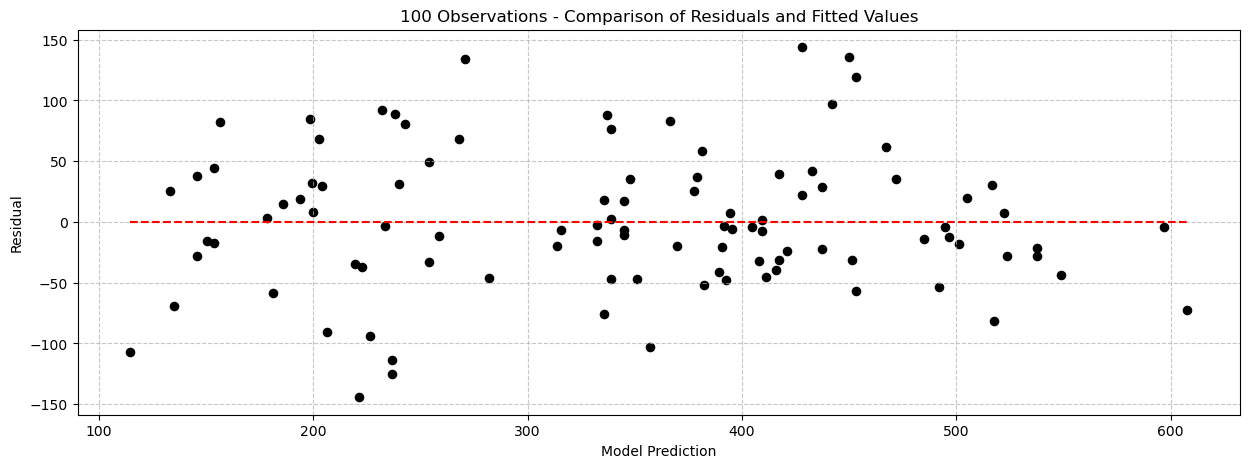


                                                          Y vs Experience, Weight                                                           

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     217.0
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           1.55e-36
Time:                        19:35:04   Log-Likelihood:                -546.75
No. Observations:                 100   AIC:                             1100.
Df Residuals:                      97   BIC:                             1107.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025 

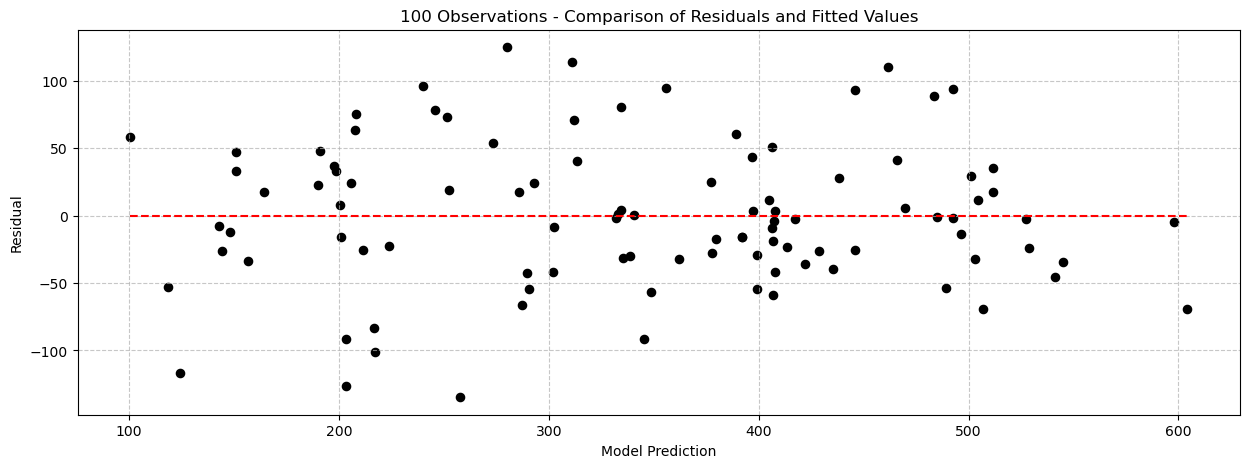


                                                      Y vs Experience, Height, Weight                                                       

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     168.3
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           4.27e-38
Time:                        19:35:04   Log-Likelihood:                -540.07
No. Observations:                 100   AIC:                             1088.
Df Residuals:                      96   BIC:                             1099.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025 

In [70]:
#Part i, ii, iii - Running Linear regression for 100 observations

for feat in features:
    plot_lin_reg(df_coll, feat)
    stat_lin_reg(df_coll, feat)

##### Conclusion

1. Height and weight do influence Y when compared individually, but their effect is smaller compared to experience, which has a much stronger impact (around 95 to 100 times the change in Y).
2. When compared together, the impact of weight reduced, suggesting some overlap in their influence

3. The R-squared values (which measure how well the model explains Y) are all above 80%, meaning height and weight are strong predictors of Y. The highest accuracy is achieved when both height and weight are used together, rather than separately.
4. We get clearer results as the number of observations increase. 
    * Based on the t-statistics results(see Appendix for details), height and weight appear to be collinear and their effects cancel each other out under fewer observations.
    * As observations increase, height's effect becomes more consistent on Y thus making it a more reliable predictor than weight

#### Question 4b: Explanation of Patterns

From our analysis, we observed varying significance levels for the independent variables across different models. In the initial model with only Height or Weight as predictors, both showed less significant relationships with the dependent variable Y, as shown by their low p-values (below 0.05). This suggests that individually, both height and weight provide explain Y well. However, when studied together (with height and weight in the same model), the t-statistics for each dependent variable became statistically insignificant. This occurs most likely due to collinearity.

In the presence of collinearity, as seen in our model for 25 observations, the influence of each variable becomes less clear, which is why the inclusion of both height and weight together reduces the significance of each predictor. Collinearity makes it harder to predict the individual impact of the independent variables.

### Appendix

#### Co-efficients and R-Squared Analysis

As seen above both height and weight (together and separately) explain Y values as the coefficients of each are non-zero

| Comparison | Equation (25 Observations)    | Equation (100 Observations)  |
|--------------------|--------------------|-------------|
| Height |(101.77 x Experience) + **(1.67 x Height)** + (-39.54) | (96.25 x Experience) + **(1.28 x Height)** + (0.92) |
| Weight |(110.39 x Experience) + **(1.60 x Weight)** + (-69.93) | (95.68 x Experience) + **(1.55 x Weight)** + (-10.46) |
|Height & Weight |(101.12 x Experience) + **(2.06 x Height) + (-0.58 x Weight)** + (-26.54) | (96.25 x Experience) + **(1.30 x Height) + (-0.04 x Weight)** + (1.60) |

However, when compared to Experience (which influences Y by a factor x95 to x100 approximately), a unit increase the Height and/or the Weight  will alter the Y value, but not to a great degree.


Reviewing R-squared values for all models:


| Comparison | R-Squared (25 Observations)    | R-Squared (100 Observations)  |
|--------------------|--------------------|-------------|
| Height |0.87844 | 0.84020 |
| Weight |0.85529 | 0.81734 |
|Height & Weight |0.87967 | 0.84021 |


As seen in the table, all R values are over 80%, therefore implying that both Height and Weight are strong predictors of Y. Height and Weight together score higher than when used alone.

#### T-Stat Analysis


Assuming 95% confidence interval that the observed results have a relations (alpha = 0.05)

Comparison	p-value (25 Observations)	p-value (100 Observations)
Height	0.005	0.000
Weight	0.041	0.000
Height
Weight	0.052
0.649	0.000
0.945

##### 25 Observations Model i: Analysis of Height
Height appears to explain Y. Since p-value of 0.005 < 0.05, there is a strong relationship between height and Y with each unit increase in height increasing Y value by x1.67.

Model ii: Analysis of Weight
Weight appears to explain Y. Since p-value of 0.041 < 0.05, there is a strong relationship between weight and Y with each unit increase in weight increasing Y value by x1.60.

Model iii: Analysis of Weight & Height

Both height and weight don't explain y. Since p-value of 0.052 > 0.05 (Height) and p-value of 0.649 > 0.05 (Weight), height and weight are statistically not significant to Y.
This suggests collinearity, height and weight are correlated causing individual effects to become insignificant when both are included

##### 100 Observations Model i: Analysis of Height
Height appears to explain Y. Since p-value of 0.000 < 0.05, there is a strong relationship between height and Y with each unit increase in height increasing Y value by x1.28.

Model ii: Analysis of Weight
Weight appears to explain Y. Since p-value of 0.000 < 0.05, there is a strong relationship between weight and Y with each unit increase in weight increasing Y value by x1.60.

Model iii: Analysis of Weight & Height

Height explain Y but weight doesn't. Since p-value of 0.000 < 0.05 (Height), p-value of 0.945 > 0.05 (Weight), weight is statistically not significant to Y. But there is a strong relationship between height and Y with each unit increase in height increasing Y by a value of 1.30
There is no strong evidence of collinearity and height becomes the dominant influence of Y over wieght

##### Conclusion:

As sample size increases, height becomes the dominant feature over Weight.
The changes in coefficient values across samples for Height and Weight indicate that the effect of height stabilizes as sample size increases

#### Standard Deviation


********************************************************************************************************************************************
                                                      Y vs Experience, Height                                                       
********************************************************************************************************************************************

The linear regression model for 25 observations is: Y = (101.77 x Experience) + (1.67 x Height) + (-39.538853)
R-squared value: 0.87844


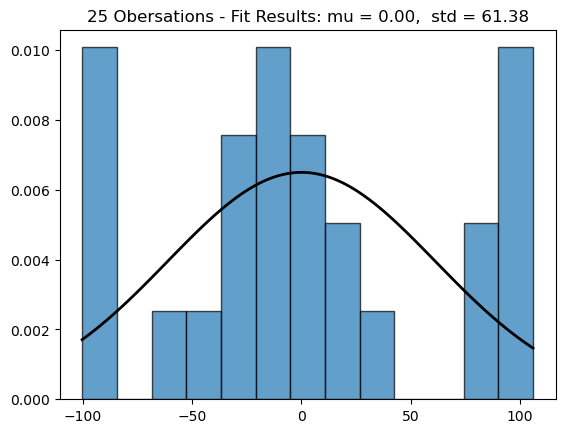


********************************************************************************************************************************************
                                                      Y vs Experience, Weight                                                       
********************************************************************************************************************************************

The linear regression model for 25 observations is: Y = (110.39 x Experience) + (1.60 x Weight) + (-69.932219)
R-squared value: 0.85529


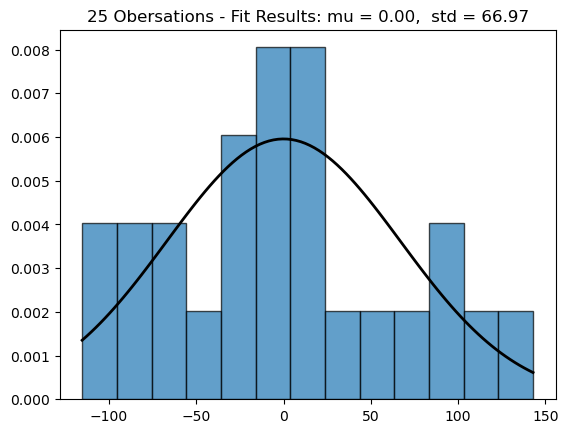


********************************************************************************************************************************************
                                                  Y vs Experience, Height, Weight                                                   
********************************************************************************************************************************************

The linear regression model for 25 observations is: Y = (101.12 x Experience) + (2.06 x Height) + (-0.58 x Weight) + (-26.536232)
R-squared value: 0.87967


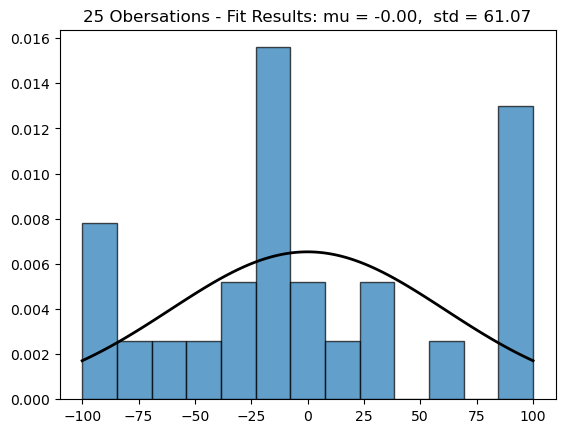

In [82]:
df_coll_25  = df_coll.iloc[:25]
df_coll_25  = df_coll_25.copy()

for feat in features:
    plot_histogram(df_coll_25, feat)


********************************************************************************************************************************************
                                                      Y vs Experience, Height                                                       
********************************************************************************************************************************************

The linear regression model for 100 observations is: Y = (96.25 x Experience) + (1.28 x Height) + (0.924141)
R-squared value: 0.84020


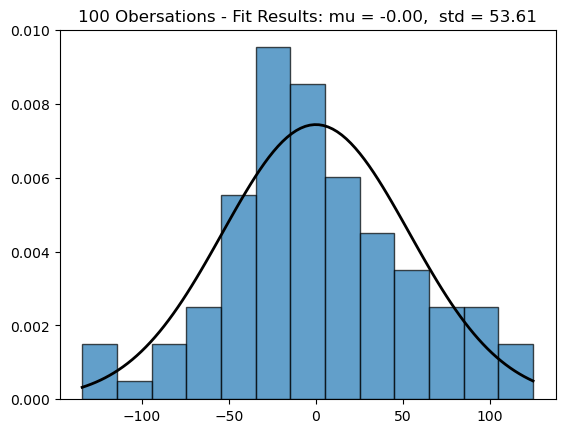


********************************************************************************************************************************************
                                                      Y vs Experience, Weight                                                       
********************************************************************************************************************************************

The linear regression model for 100 observations is: Y = (95.68 x Experience) + (1.55 x Weight) + (-10.461390)
R-squared value: 0.81734


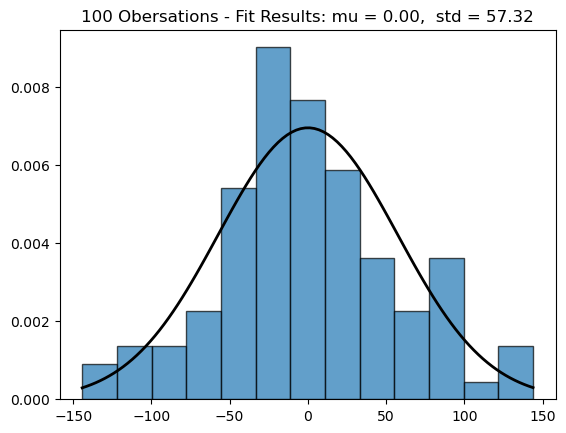


********************************************************************************************************************************************
                                                  Y vs Experience, Height, Weight                                                   
********************************************************************************************************************************************

The linear regression model for 100 observations is: Y = (96.25 x Experience) + (1.30 x Height) + (-0.04 x Weight) + (1.599411)
R-squared value: 0.84021


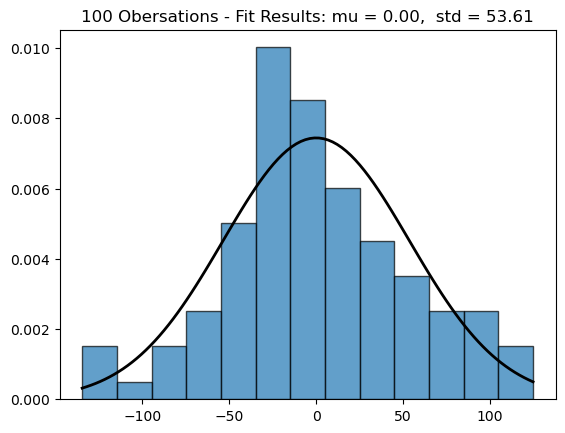

In [84]:
for feat in features:
    plot_histogram(df_coll, feat)